# Model tuning

Após selecionarmos as melhores features para nosso modelo, o que faremos nesse notebook será o tuning de hiperparametros do lightgbm. A ideia é encontrar o melhor conjunto de parametros para trazer algum ganho incremental de performance na nossa solução e, principalmente, encontrar parâmetros que diminuam o risco de overfitting do modelo.

Essa redução no risco de overfitting de um modelo de árvore se dá devido a alguns fatores, como:
* Controle no processo de crescimento das árvores;
* Controle na quantidade de nós de decisão das árvores;
* Restrição na quantidade de samples e features que, aleatoriamente, o algoritmo irá usar para treinar as árvores em cada iteração;
* Regularização da função objetivo através dos parametros reg_alpha e reg_lambda, por exemplo.

Para reduzir o tempo de execução, iremos definir um vasto espaço de busca e utilizar o RandomizedSearchCV do scikit-learn que, aleatoriamente, irá testar algumas combinações. Em alguns casos, quando se tem uma melhor ideia de como construir o espaço de busca, também pode ser utilizado o GridSearchCV, que testa todas as combinações possíveis dentro de um grid. Outra alternativa também é usar algoritmos de otimização como o hyperopt e optuna para decidir os melhores parâmetros.

In [1]:
#importando as bibliotecas que serão utilizadas no processo
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score

import FeatureGenerator as fg

from lightgbm import LGBMClassifier

In [2]:
#carregando os dados de treino
data_path = "../inputs/train.csv"
df_train = pd.read_csv(data_path)
df_train.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,28104,50000.0,2,1,1,31,1,2,2,0,...,50332.0,29690.0,30246.0,2200.0,4.0,2300.0,1100.0,1400.0,1200.0,1
1,29094,330000.0,2,2,2,59,0,0,0,0,...,80589.0,76180.0,61693.0,20000.0,3500.0,19000.0,15000.0,3000.0,2139.0,0
2,11280,220000.0,2,1,2,41,-1,-1,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,28435,50000.0,2,2,1,45,0,0,0,0,...,8469.0,8411.0,8361.0,2124.0,2037.0,1130.0,295.0,302.0,296.0,0
4,10873,480000.0,2,3,1,42,-2,-2,-2,-2,...,0.0,790.0,0.0,0.0,0.0,0.0,790.0,0.0,0.0,0


In [3]:
#selecionando as variáveis categóricas para definir no modelo
cat_cols = ['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [4]:
#o lightgbm irá converter para NaN todas as variáveis categóricas que forem menor que 0
#para esses casos, teremos que aplicar um tratamento diferente
#vamos escolher um valor qualquer negativo para multiplicar as categorias negativas e criar novas categorias positivas
def negative_cat(value):
    if value < 0:
        value = value*(-15)
        
    else:
        pass
    
    return value

In [5]:
#aplicando a função
for c in cat_cols:
    df_train[c] = df_train[c].apply(negative_cat)

In [6]:
#inicializando as classes que serão utilizadas para geração de features
#a ideia de utilizar classes é poder encapsular tudo num só pipeline

#classe para criar as features de divisão
fbf = fg.FeatureByFeature(features_num=["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"],
                         features_denom=["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"])

#classe para criar as features de diferença
diff1 = fg.DiffFeatures(features=["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"])

diff2 = fg.DiffFeatures(features=["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"])

#classe para dropar features que não serão necessárias
dc = fg.DropCols(features=["ID"])

In [7]:
#criando input e output
X_train, y_train = df_train.drop(columns=["target"], axis=1), df_train.target.values

In [8]:
#o lightgbm só aceita index para identificação das colunas categoricas
cat_idx = []
for c in cat_cols:
    #aqui estamos subtraindo 1 do index porque a coluna "ID" será removida, alterando o index das colunas restantes
    idx = X_train.columns.get_loc(c) - 1
    cat_idx.append(idx)

In [9]:
#inicializando o lightgbm
base_estimator = LGBMClassifier(categorical_features=cat_idx,
                              class_weight="balanced",
                              random_state=42)

In [10]:
#definindo o nosso pipeline com as transformações e o algoritmo final
pipe = Pipeline(steps=[("DropCols", dc),
                       ("FeatureByFeature", fbf),
                      ("diff_features1", diff1),
                      ("diff_features2", diff2),
                      ("Estimator", base_estimator)])

In [11]:
#aqui definimos o nosso grid de busca onde o tuning de parametros buscará as melhores combinações
distributions = {"Estimator__n_estimators": [100, 200, 300, 500, 650, 800, 1000, 1200, 1600, 2000],
                "Estimator__colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, None],
                "Estimator__max_depth": [2, 4, 6, 8, 10],
                "Estimator__num_leaves": [12, 16, 20, 31, 41],
                "Estimator__min_child_samples": [20, 30, 40, 50, 60, 80, 100],
                "Estimator__reg_alpha": [2, 4, 6, 8, 10, 12, 16],
                "Estimator__reg_lambda": [2, 4, 6, 8, 10, 12, 16],
                "Estimator__learning_rate": [0.3, 0.1, 0.08, 0.06, 0.04, 0.03, 0.02, 0.01, 0.008, 0.005]}

In [12]:
#vamos utilizar a validação cruzada para avaliar o modelo em diferentes partições do dataset
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
#inicializando o random search
clf = RandomizedSearchCV(pipe, distributions, cv=cross_val, scoring="f1")

In [14]:
#fit
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('DropCols',
                                              DropCols(features=['ID'])),
                                             ('FeatureByFeature',
                                              FeatureByFeature(features_denom=['BILL_AMT1',
                                                                               'BILL_AMT2',
                                                                               'BILL_AMT3',
                                                                               'BILL_AMT4',
                                                                               'BILL_AMT5',
                                                                               'BILL_AMT6'],
                                                               features_num=['PAY_AMT1',
                                                                             '

In [15]:
#Vamos analisar os 3 melhores resultados e ver  os parâmetros que iremos utilizar adiante
results = pd.DataFrame(clf.cv_results_)
results = results.sort_values(by="rank_test_score", ascending=True)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Estimator__reg_lambda,param_Estimator__reg_alpha,param_Estimator__num_leaves,param_Estimator__n_estimators,param_Estimator__min_child_samples,param_Estimator__max_depth,...,param_Estimator__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,4.236459,0.026459,0.150948,0.021507,4,12,12,500,60,8,...,None,"{'Estimator__reg_lambda': 4, 'Estimator__reg_a...",0.551791,0.522293,0.548209,0.528428,0.556530,0.541450,0.013540,1
7,1.030892,0.030551,0.068856,0.018875,2,12,20,100,30,8,...,0.6,"{'Estimator__reg_lambda': 2, 'Estimator__reg_a...",0.550627,0.519120,0.552522,0.526466,0.553743,0.540496,0.014673,2
8,9.179514,1.791346,0.602046,0.080484,8,16,16,1200,60,10,...,0.5,"{'Estimator__reg_lambda': 8, 'Estimator__reg_a...",0.550669,0.519369,0.544783,0.526718,0.555449,0.539398,0.013969,3


In [16]:
#melhores parametros do processo de tuning
clf.best_params_

{'Estimator__reg_lambda': 4,
 'Estimator__reg_alpha': 12,
 'Estimator__num_leaves': 12,
 'Estimator__n_estimators': 500,
 'Estimator__min_child_samples': 60,
 'Estimator__max_depth': 8,
 'Estimator__learning_rate': 0.005,
 'Estimator__colsample_bytree': None}

In [17]:
#criando nosso dicionário de parâmetros para configurar o modelo
selected_params = {'reg_lambda': 4,
 'reg_alpha': 12,
 'num_leaves': 12,
 'n_estimators': 500,
 'min_child_samples': 60,
 'max_depth': 8,
 'learning_rate': 0.005,
 'colsample_bytree': None}

In [18]:
#inicializando um novo lightgbm, agora com os parâmetros escolhidos
estimator = LGBMClassifier(**selected_params,
                           categorical_features=cat_idx,
                           class_weight="balanced",
                           random_state=42)

In [19]:
#configurando o pipeline com o novo modelo inicializado
pipe = Pipeline(steps=[("DropCols", dc),
                       ("FeatureByFeature", fbf),
                      ("diff_features1", diff1),
                      ("diff_features2", diff2),
                      ("Estimator", estimator)])

In [20]:
#usando a validação cruzada para avaliar o novo modelo
print(cross_val_score(pipe, X_train, y_train, cv=cross_val, scoring="f1"))

[0.5517909  0.52229299 0.54820937 0.52842809 0.55653021]


In [21]:
#resultado médio da validação cruzada
print(np.mean([0.5517909,  0.52229299, 0.54820937, 0.52842809, 0.55653021]))

0.5414503119999999


Obtivemos uma melhoria pequena em relação ao modelo default, mas vamos seguir com o modelo tunado pelas seguintes razões:

1. O modelo tunado possui regularização alpha e lambda, o que reduz o risco de termos overfitting, tornando o modelo mais adequado em termos de generalização;

2. O modelo tunado possui algumas restrições de crescimento de árvore, como min_child_samples e num_leaves, o que também torna o modelo menos suscetível a overfitting.

### Seleção de threshold

Outro parâmetro importante em um modelo de classificação é o threshold de probabilidade que o modelo está utilizando para decidir se um determinado input deve ser classificado como 0 ou 1. Aqui vamos avaliar em que valor esse corte deve estar para gerar os melhores resultados

In [22]:
#função para converter probabilidade para classe
def prob2class(value, thresh):
    if value > thresh:
        return 1
    else:
        return 0

In [23]:
#vamos carregar uma base de validação para fazer o ajuste de threshold
eval_set = pd.read_csv("../inputs/validation.csv")

In [24]:
#criando input e output de validação
X_val, y_val = eval_set.drop(columns="target", axis=1), eval_set.target.values

In [25]:
#aplicando a função
for c in cat_cols:
    X_val[c] = X_val[c].apply(negative_cat)

In [27]:
#fit do pipeline nos dados de treino
pipe.fit(X_train, y_train)

Pipeline(steps=[('DropCols', DropCols(features=['ID'])),
                ('FeatureByFeature',
                 FeatureByFeature(features_denom=['BILL_AMT1', 'BILL_AMT2',
                                                  'BILL_AMT3', 'BILL_AMT4',
                                                  'BILL_AMT5', 'BILL_AMT6'],
                                  features_num=['PAY_AMT1', 'PAY_AMT2',
                                                'PAY_AMT3', 'PAY_AMT4',
                                                'PAY_AMT5', 'PAY_AMT6'])),
                ('diff_features1',
                 DiffFeatures(features=['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                                        'PAY_AMT4', '...
                ('diff_features2',
                 DiffFeatures(features=['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
                                        'BILL_AMT4', 'BILL_AMT5',
                                        'BILL_AMT6'])),
                ('Estimator',
                 LGBMCla

In [28]:
#gerando as predições de probabilidade
#vamos criar uma coluna que contém as probabilidades como informação
y_proba = pipe.predict_proba(X_val)
y_proba = [p[1] for p in y_proba]
X_val["probability"] = y_proba

In [29]:
#definindo o espaço de análise dos thresholds
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
f1s = []

In [30]:
#laço para calcular a performance do modelo em diferentes thresholds
for t in thresholds:
    X_val["prediction"] = X_val.apply(lambda x: prob2class(x["probability"], thresh=t), axis=1)
    y_pred = X_val["prediction"].values
    
    f1 = f1_score(y_val, y_pred)
    f1s.append(f1)

Text(0.5, 1.0, 'Threshold selection for f1_score')

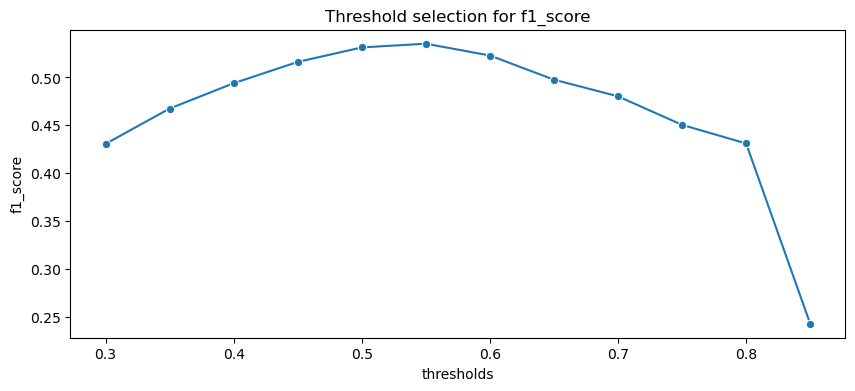

In [31]:
#plotando o gráfico de threshold vs f1
plt.figure(figsize=(10, 4))
sns.lineplot(x=thresholds, y=f1s, marker='o')
plt.xlabel("thresholds")
plt.ylabel("f1_score")
plt.title("Threshold selection for f1_score")

O nosso threshold final então está em 0.55. Note que a definição do threshold foi realizada com base em um dataset de validação. Nesse caso, o correto é ter uma terceira partiçao de dados para avaliar o quanto que, nessas condições que foram encontradas, o modelo é capaz de generalizar em dados nunca vistos.

# Outras abordagens

Para tentar incrementar a performance do nosso modelo, poderíamos testar outras técnicas como as arquiteturas de ensemble, como voting e stacking utilizando outros modelos como catboost e xgboost em combinação com o lightgbm.